<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Introduction</h3>


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>In the process of solving the problem we are facing in this competition, there are various paths to be taken.</span></p>
<p style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">I believe that for a future model, a narrower search space can be obtained by narrowing down the translation process to a smaller subset of options, which include only the observable elements in the image stated by letter.</span></span></p>
<p style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><br></span></span></p>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>This notebook presents a suggestion for an image processing pipeline that can retrieve the letters from a given chemical image.</span></p>
<p><br></p>

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Libraries And Utilities</h3>


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import cv2, os
import skimage.io as io
from tqdm.auto import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure',figsize=(18,11))
plt.rc('image',cmap='Blues')

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Loading The Data</h3>


In [ ]:
labels = pd.read_csv('../input/bms-molecular-translation/train_labels.csv')
ss = pd.read_csv('../input/bms-molecular-translation/sample_submission.csv', index_col = 0)

labels['path'] = labels['image_id'].progress_apply(
    lambda x: "../input/bms-molecular-translation/train/{}/{}/{}/{}.png".format(
        x[0], x[1], x[2], x))
labels.head()


  0%|          | 0/2424186 [00:00<?, ?it/s]

,image_id,InChI,path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,../input/bms-molecular-translation/train/0/0/0...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,../input/bms-molecular-translation/train/0/0/0...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,../input/bms-molecular-translation/train/0/0/0...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,../input/bms-molecular-translation/train/0/0/0...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,../input/bms-molecular-translation/train/0/0/0...


<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Going Through The Logic</h3>


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Our letter retrieval pipeline will consist of 3 main steps that will be explained in the following section:</span></p>
<ol>
    <li style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">Preprocess the image using morphological transformations.</span></span></li>
    <li style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">Detect contours in the processed image</span></span></li>
    <li style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Remove contours that deviate from our criteria</span></li>
</ol>

<h3 style="background-color:None;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">1 - Preprocessing The Image</h3>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We will use dilation and erosion to fix the inconsistency in lines and the noise accompanied by most of the images.
The entire purpose of the preprocessing stage is to create better structures for our contour detection stage.</span></p>
<p><br></p>

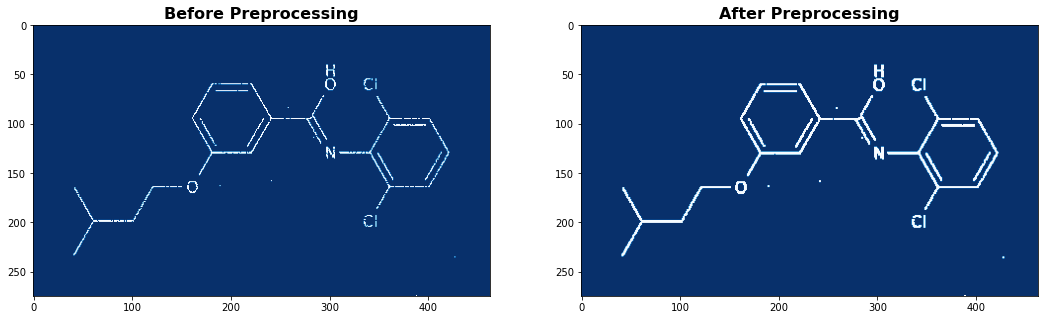

In [ ]:
plt.subplot(2,2,1)
plt.title('Before Preprocessing',fontsize=16,fontweight='bold')
plt.imshow(plt.imread(labels.path[14]))
plt.subplot(2,2,2)
t1 = cv2.erode(plt.imread(labels.path[14]),np.ones((2,2)))
plt.title('After Preprocessing',fontsize=16,fontweight='bold')
plt.imshow(t1)
plt.show()

<h3 style="background-color:None;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">2 - Detecting Contours </h3>


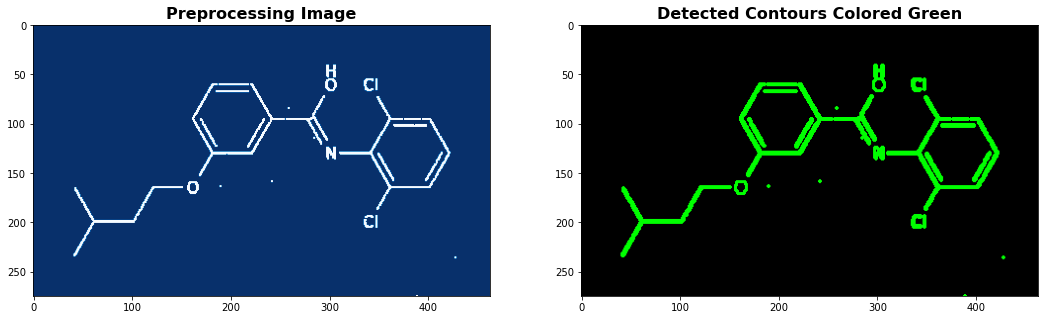

In [ ]:
plt.subplot(2,2,1)
plt.title('Preprocessing Image',fontsize=16,fontweight='bold')
plt.imshow(t1)
plt.subplot(2,2,2)

t1 = 255 + t1
contours, hierarchy = cv2.findContours(t1.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )
img = cv2.cvtColor(np.zeros_like(t1),cv2.COLOR_GRAY2RGB)
wc = cv2.drawContours(img, contours, -1, (0,255,0), 2)

plt.title('Detected Contours Colored Green',fontsize=16,fontweight='bold')
plt.imshow(wc)
plt.show()

<h3 style="background-color:None;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">3 - Process Detected Contours </h3>

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We will make the following assumption, every letter present in a given image can be bound by a rectangle which tends to be a square, i.e., the difference between orthogonal sides tends to be equal to zero.</span></p>
<p style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">We also know that we can bound a square with a minimum-sized circle which will grow larger in a rectangle case.</span></span></p>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Using these assumptions, we will bound every contour we find with a rectangle and a circle; we will then condition the validity of a contour based on the bounding circle area and the difference between orthogonal sides.</span></p>

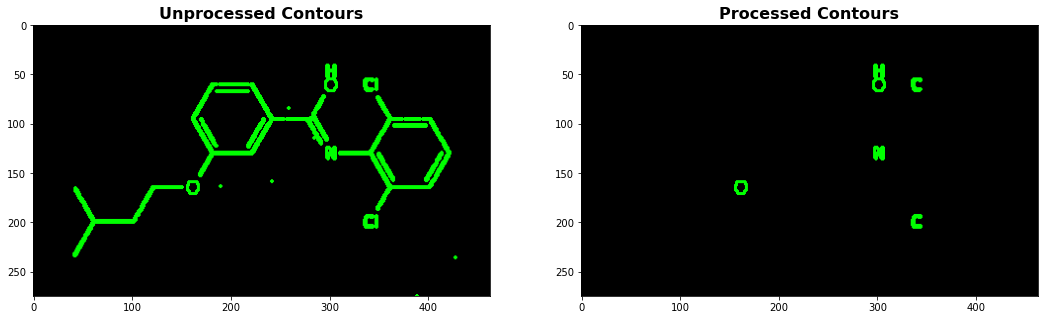

In [ ]:
cnts = []
barea = lambda x: np.linalg.norm(x[0]-x[1])*np.linalg.norm(x[0]-x[3])
bsd = lambda x: np.abs(np.linalg.norm(x[0]-x[1])-np.linalg.norm(x[0]-x[3]))
for cnt in contours:
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)

    #if contour bonding box sides are not more different then alpha
    #and the bounding circle area is between beta1 and beta 2
    #save contour else ignore it
    if (20<np.pi *radius**2 < 450) and bsd(box)<10:
        cnts.append(cnt)
        
        
plt.subplot(2,2,1)
plt.title('Unprocessed Contours',fontsize=16,fontweight='bold')
plt.imshow(img)
plt.subplot(2,2,2)

img = cv2.cvtColor(np.zeros_like(t1),cv2.COLOR_GRAY2RGB)
wc = cv2.drawContours(img, cnts, -1, (0,255,0), 2)

plt.title('Processed Contours',fontsize=16,fontweight='bold')
plt.imshow(wc)
plt.show()

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Letter Retrieval Pipeline</h3>


In [ ]:
def clean_image(img,alpha = 10,beta1=20,beta2=450,pr_mode=1,kernel_size=2):
    
    """
     
    Parameters
    ----------
    img : np.array
        an image of a chemical compound
    alpha : float
        the maximum allowed difference between bouding rectangle sides ,0 differnce means all sides are equal i.e square
    beta1 : float
        the minimum area of the circle which bound the contour found 
    beta2 : int
        the maximum area of the circle which bound the contour found 
    pr_mode : int
        preprocessing preset value can be 1,2 or 3 
    kernel_size : int
        kernel size for morphological operations in preprocessing  
        
    """
    
    t1 =img.copy().astype(np.uint8)
    #preprocess the image so better contours can be detected
    if pr_mode ==1 :
        t1 = cv2.erode(t1,np.ones((kernel_size,kernel_size)))
    elif pr_mode == 2:
        t1 = cv2.morphologyEx(t1,cv2.MORPH_OPEN,np.ones((kernel_size,kernel_size)))
    else:
        t1 = cv2.morphologyEx(t1,cv2.MORPH_GRADIENT,np.ones((kernel_size,kernel_size)))


    t1 = t1 + 255
    
    #create canvas to draw contours on
    img = cv2.cvtColor(np.zeros_like(t1),cv2.COLOR_GRAY2RGB)
    
    #find contours
    contours, hierarchy = cv2.findContours(t1.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )

    cnts = []
    
    #function for box area calculation
    barea = lambda x: np.linalg.norm(x[0]-x[1])*np.linalg.norm(x[0]-x[3])
    #function for box side difference calculation
    bsd = lambda x: np.abs(np.linalg.norm(x[0]-x[1])-np.linalg.norm(x[0]-x[3]))

    #preprocess contours
    for cnt in contours:
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        #if contour bonding box sides are not more different then alpha
        #and the bounding circle area is between beta1 and beta 2
        #save contour else ignore it
        if (beta1<np.pi *radius**2 < beta2) and bsd(box)<alpha:
            cnts.append(cnt)
    
    wc = cv2.drawContours(img, cnts, -1, (0,255,0), 2)
    wc =  cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    
    return cv2.bitwise_and(t1,t1,mask=wc)


def get_letters(processed_img,scope=2):
        contours, hierarchy = cv2.findContours(processed_img.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )
        letters = []
        for cts in contours:
            rect = cv2.minAreaRect(cts)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            W = rect[1][0]
            H = rect[1][1]
            Xs = [i[0] for i in box]
            Ys = [i[1] for i in box]
            x1 = min(Xs)
            x2 = max(Xs)
            y1 = min(Ys)
            y2 = max(Ys)

            rotated = False
            angle = rect[2]

            if angle < -45:
                angle+=90
                rotated = True
                
            center = (int((x1+x2)/2), int((y1+y2)/2))
            size = (int(scope*(x2-x1)),int(scope*(y2-y1)))
            M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
            cropped = cv2.getRectSubPix(processed_img, size, center)    
            cropped = cv2.warpAffine(cropped, M, size)
            croppedW = W if not rotated else H 
            croppedH = H if not rotated else W
            croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW*scope), int(croppedH*scope)), (size[0]/2, size[1]/2))
            croppedRotated = np.rot90(croppedRotated)

            #print(box)
            letters.append(croppedRotated)

        return letters

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Examples</h3>


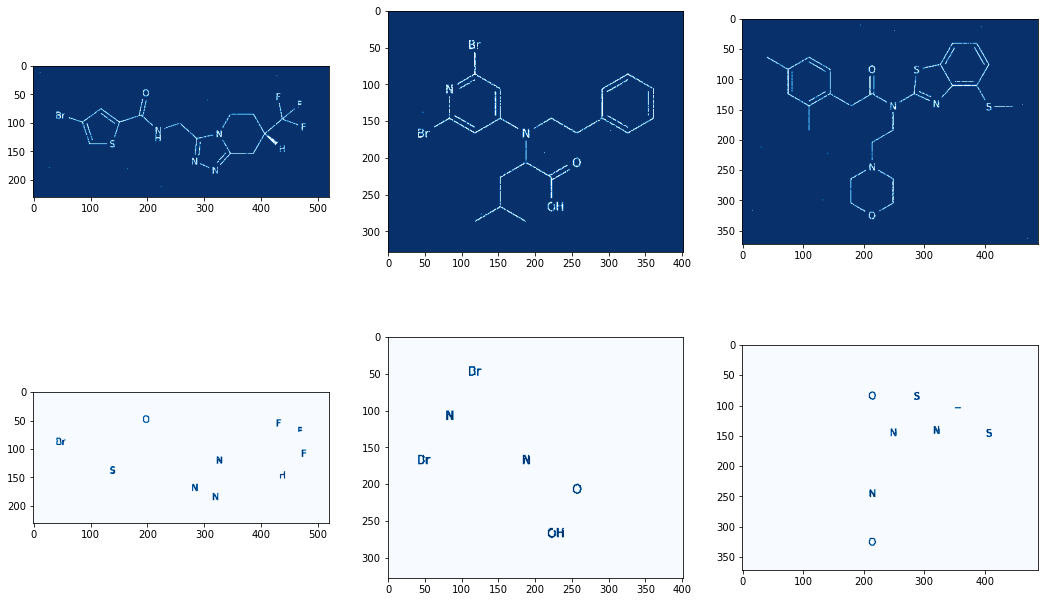

In [ ]:
imgs = [10,5,55]
fig,axs = plt.subplots(2,3)
for ix,img in enumerate(imgs):
    axs[1,ix].imshow(clean_image(plt.imread(labels.path[img])))
    axs[0,ix].imshow((plt.imread(labels.path[img])))
    

<h3 style="background-color:None;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Extracting Only The Letters</h3>


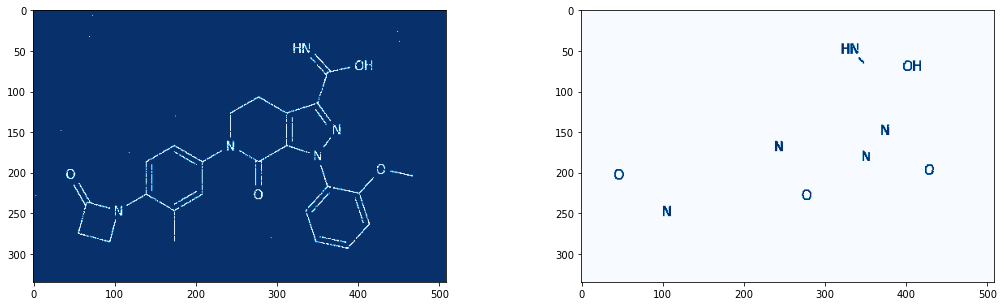

In [ ]:
plt.subplot(2,2,1)
plt.imshow((plt.imread(labels.path[2])))
plt.subplot(2,2,2)
plt.imshow(clean_image(plt.imread(labels.path[2])))
plt.show()

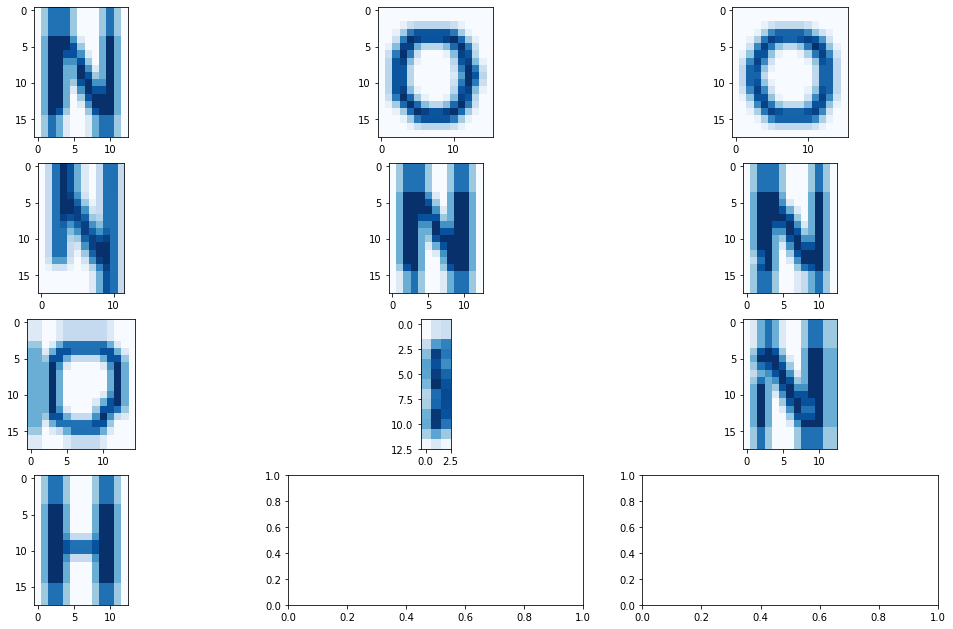

In [ ]:
letters = get_letters(clean_image(plt.imread(labels.path[2])),1.5) 
ax,ay = 0,0
L = int(np.sqrt(len(letters)))
fig,axs = plt.subplots(L+1,L)
for l in letters:
    if ax<L:
        axs[ay,ax].imshow(l)
        ax+=1
    else:
        ay+=1
        ax=0
        axs[ay,ax].imshow(l)
    #plt.imshow(l)
plt.show()

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Conclusions and Further Directions</h3>


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>The current version of the pipeline does a fair job given the default parameters; the image&apos;s resolution needs to be taken into account as it directly affects the alpha,beta1, and beta2 parameters.</span></p>
<p style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">Future work on this path will include running a detection pipeline on the resulting image to convert the retrieved letters into a string that can be fed into an independent process.</span></span></p>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'><br></span></p>
<p><br></p>

# **Advanced Chemical Engineering Projects** 

*   Chemical properity prediction.
*   generative modeling in drug discovery
*   hydrogen sensing by using AI based on optical sensor




